<div align="center">
      <h1>Introduction to k-Nearest Neighbors</h1>
      <hr>
      <p>This activity serves as a review of the k-Nearest Neighbors (k-NN) classifier, which you have previously encountered in the KUI course. Its purpose is to refresh your understanding of fundamental concepts related to machine learning classification tasks.</p>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

## Dataset and Classification Task

In supervised machine learning, a typical dataset consists of two main components:

1. **Features** - These are the characteristics that describe the data. Usually, a sample is represented as a vector of features, denoted as $\boldsymbol{x} = (x_{1}, x_{2}, ..., x_{d})$. In this assignment, the number of features will be referred to as $d$.

2. **Labels** - These are the values we aim to predict. In this assignment, we'll use $y$ to denote the labels.

The role of the classifier is to take a feature vector $\boldsymbol{x}$ and predict the corresponding label $y$. Mathematically, this can be represented as a function $f$ that maps features to labels:

$$f: \mathbb{R}^{d} \rightarrow \mathcal{Y}$$

$$f(\boldsymbol{x}) = y, \quad \boldsymbol{x} \in \mathbb{R}^{d}, \quad y \in \mathcal{Y}$$

Once you have your dataset with features and labels, it's crucial to divide it into distinct subsets for training, validation, and testing. These subsets serve specific purposes during the model development and evaluation process:

1. **Training Set** - This is the largest portion of your dataset and is used to train the model. The model learns underlying patterns in the data by adjusting its parameters based on the training examples. A larger training set generally helps the model learn more accurate and generalizable patterns.

2. **Validation Set** - This subset is used during training for hyperparameter tuning and model selection. Hyperparameters are settings that are not learned by the model during training, such as the learning rate or the number of hidden layers in a neural network. The model's performance on the validation set helps in selecting the best hyperparameters and prevents overfitting, where the model becomes too tailored to the training data and performs poorly on new, unseen data.

3. **Test Set** - This set is entirely independent of the training and validation data. Its purpose is to evaluate the final model's performance after it has been trained and tuned. Using a separate test set provides an unbiased estimate of how well the model is likely to perform on new, unseen data. This step is essential for assessing the model's generalization capabilities.

*__Note__: In some situations, the terms "validation set" and "test set" may be used interchangeably. For example, in online literature, the validation set is often referred to as the test set. Additionally, in certain research papers, there may not be a distinct test set, and model evaluation is performed solely on the validation set. However, for this assignment, we will treat the validation and testing sets as separate entities.*

Typical ratios for splitting the dataset include allocating 70-80% for training, 10-15% for validation, and another 10-15% for testing. However, these ratios can vary depending on the dataset size and the specific problem you're addressing. In cases where data is limited, techniques like **cross-validation** can be applied to maximize the utility of available data.

To summarize, the training set teaches the model, the validation set aids in fine-tuning hyperparameters, and the test set offers an unbiased evaluation of performance. Properly segmenting these subsets is essential for effective and fair development and assessment of machine learning models.


### The Data We'll Use

Now, we'll work with a simple dataset designed for a classification task. This dataset comprises three classes of points in a 2D feature space. These points are generated from three distinct Gaussian distributions. The objective is to train a classifier capable of predicting the class to which a new point belongs.

---------------- Training data ----------------
X_train shape: (1125, 2), y_train shape: (1125,)

---------------- Validation data ----------------
X_val shape: (187, 2), y_val shape: (187,)

---------------- Testing data ----------------
X_test shape: (188, 2), y_test shape: (188,)

---------------- Dataset info ----------------
Number of features: 2
Number of classes: 3
Number of samples in dataset: 1500
Number of samples in training set: 1125, which is 75.00% of the dataset
Number of samples in validation set: 187, which is 12.47% of the dataset
Number of samples in testing set: 188, which is 12.53% of the dataset


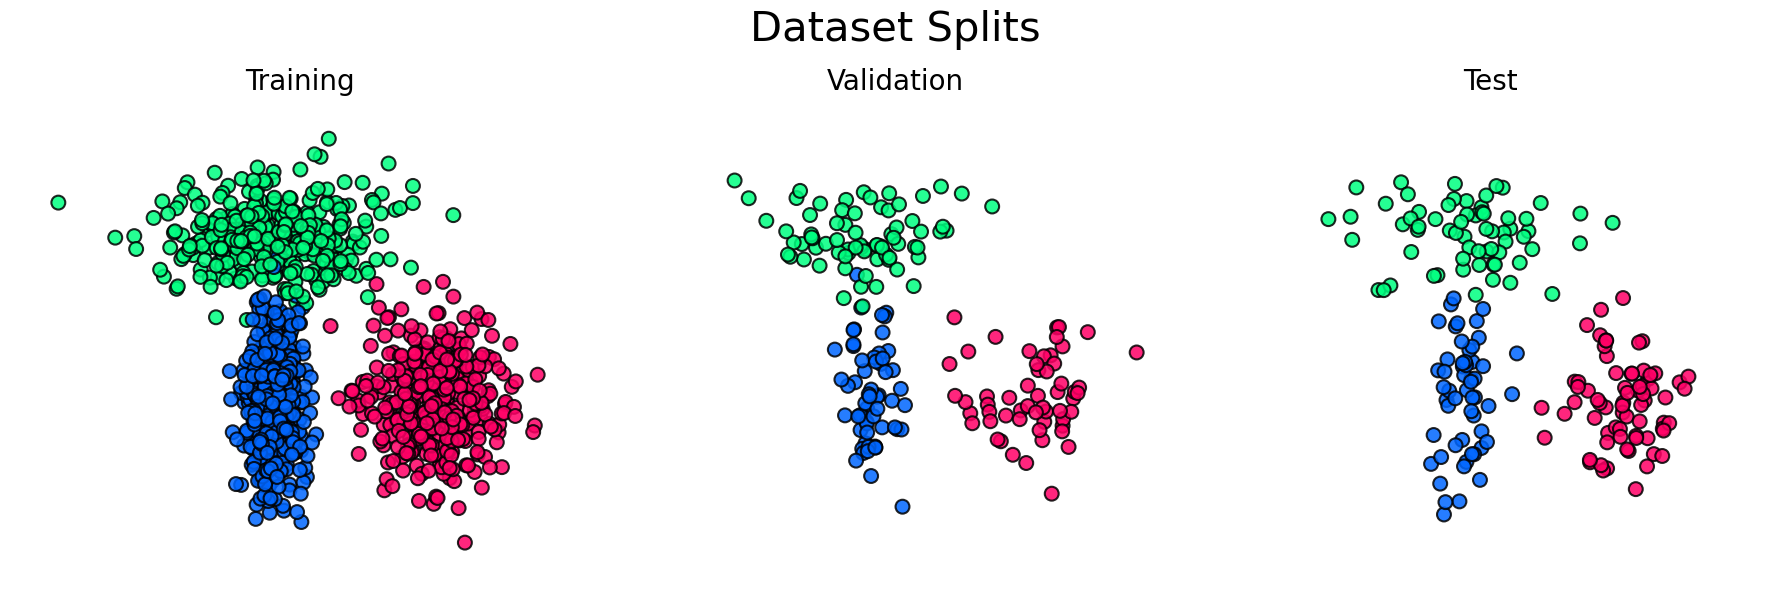

In [2]:
from utils import Visualizer

# Load the dataset
dataset = np.load('data/datasets/linearly_separable.npz')

X_train, y_train = dataset['X_train'], dataset['y_train']
X_val, y_val = dataset['X_val'], dataset['y_val']
X_test, y_test = dataset['X_test'], dataset['y_test']

# Print the shapes of the data
print('---------------- Training data ----------------')
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

print('\n---------------- Validation data ----------------')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

print('\n---------------- Testing data ----------------')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

print('\n---------------- Dataset info ----------------')
print(f'Number of features: {X_train.shape[1]}')
print(f'Number of classes: {len(np.unique(y_train))}')
print(f'Number of samples in dataset: {len(X_train) + len(X_val) + len(X_test)}')
print(f'Number of samples in training set: {len(X_train)}, '
      f'which is {100 * len(X_train) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')
print(f'Number of samples in validation set: {len(X_val)}, '
      f'which is {100 * len(X_val) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')
print(f'Number of samples in testing set: {len(X_test)}, '
      f'which is {100 * len(X_test) / (len(X_train) + len(X_val) + len(X_test)):.2f}% of the dataset')

vis = Visualizer((X_train, y_train), (X_val, y_val), (X_test, y_test))
vis.show_dataset()

## Nearest Neighbors Classifier

The Nearest Neighbors classifier is a straightforward algorithm that operates as follows:

1. **Training** - The classifier essentially memorizes the training dataset. The training set is stored in the classifier and used for prediction.
2. **Prediction** - When making predictions, the classifier identifies the closest sample in the training set to the given input and assigns the label of the closest sample to the input.

There are various methods to determine the closest sample, but for this assignment, we'll utilize the Euclidean distance metric. The Euclidean distance between two samples, denoted as $\boldsymbol{x}_{1}$ and $\boldsymbol{x}_{2}$, is defined as:

$$d(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}) = \sqrt{\sum_{i=1}^{d} (x_{1i} - x_{2i})^{2}}$$

Here, $\boldsymbol{x}_{1}$ and $\boldsymbol{x}_{2}$ represent two samples from the dataset.

## k-Nearest Neighbors Classifier

The k-Nearest Neighbors classifier is akin to the Nearest Neighbors classifier, with one key difference. In the k-Nearest Neighbors classifier, instead of considering just the single closest sample, we find the $k$ closest samples from the training set. The classifier then assigns the label that is most prevalent among these $k$ closest samples to the given input.

To illustrate, here's an example of k-Nearest Neighbors classification with $k=3$ (the yellow point represents the point we want to classify):

<br>
<br>

<div align="center">
      <img src="data/images/knn_principle.png" alt="k-Nearest Neighbors principle">
</div>

<br>
<br>

In this example, the two nearest neighbors belong to the green class, while one belongs to the red class. Consequently, the yellow point is classified as part of the green class.

Your task involves implementing the k-Nearest Neighbors classifier. This classifier should be capable of training on the training dataset and predicting labels for given samples. The implementation should reside in the `assignments/knn_classifier.py` file, which contains the `KNNClassifier` class with the following methods:

1`_compute_distances(X)` - This method calculates the distances between the given samples and the training set.
2`_compute_distances_vectorized(X)` - Here, distances between the given samples and the training set should be computed in a vectorized manner.
3`_predict_labels(dists)` - This method predicts the labels of the given samples.

Begin by implementing the `_compute_distances(X)` method, followed by the `_predict_labels(dists)` method. Once all methods are implemented, you can execute the provided code to train the classifier and predict labels for the given samples. Remember that, you can run tests to verify the correctness of your implementation.


In [5]:
from sklearn.metrics import accuracy_score
from assignments_solution import KNNClassifier

# Create and train the classifier
knn = KNNClassifier(k=3, vectorized=False)
knn.train(X_train, y_train)

# Predict the labels of the given samples
y_pred = knn.predict(X_val)

# Compute the accuracy of the classifier, the accuracy should be around 0.98
print(f'Accuracy: {accuracy_score(y_val, y_pred):.3f}')

Accuracy: 0.984


## Vectorization

Vectorization is a technique that can enhance the speed of your code by performing multiple operations simultaneously. In Python, we achieve vectorization through the use of the NumPy library. NumPy is a Python library that offers a multidimensional array object, various related objects (including masked arrays and matrices), and a range of functions for swift operations on arrays. These operations encompass mathematical computations, logical evaluations, shape manipulation, sorting, selection, input/output operations, discrete Fourier transforms, fundamental linear algebra operations, basic statistical computations, random simulations, and much more.

In this assignment, you will apply vectorization to implement the k-Nearest Neighbors classifier efficiently. A vectorized approach is expected to be faster than a non-vectorized one. To implement the vectorized version, focus on the `_compute_distances_vectorized(X)` method within the `assignments/knn_classifier.py` file.

In [6]:
knn_vectorized = KNNClassifier(k=3, vectorized=True)
knn_vectorized.train(X_train, y_train)

# Predict the labels of the given samples
y_pred = knn_vectorized.predict(X_val)

# Compute the accuracy of the classifier. You can check that the accuracy is the same as for the non-vectorized implementation.
print(f'Accuracy: {accuracy_score(y_val, y_pred):.3f}')

Accuracy: 0.984


## Non-vectorized vs. Vectorized Implementation

Now, let's examine and compare the execution times of both the non-vectorized and vectorized implementations. We can assess the performance of these implementations using the `measure_time(classifier, X)` function. This function quantifies the time taken by the classifier to process a given dataset and returns the execution time in seconds.

In [7]:
from time import time


def measure_time(classifier: KNNClassifier, X: np.ndarray) -> float:
    """ Measures the running time of predicting the labels of the given samples.
    
    Args:
        classifier: The classifier to measure the running time of.
        X: The dataset to measure the running time on.
    
    Returns:
        The running time of the classifier in seconds.
    """

    start = time()
    _ = classifier.predict(X)
    end = time()

    return end - start


print(f'Non-vectorized implementation took {measure_time(knn, X_val):.3f} seconds')
print(f'Vectorized implementation took {measure_time(knn_vectorized, X_val):.3f} seconds')

Non-vectorized implementation took 0.544 seconds
Vectorized implementation took 0.021 seconds


<div align="center">
      <hr>
</div>

### QUESTIONS:

1. Why are NumPy operations faster than the same operations implemented in Python?
2. In general, is vectorized implementation faster than implementation with loops on a CPU? (Hint: Can a CPU perform multiple operations at once?)
3. Are there any disadvantages to vectorized implementation? If so, what are they?

### ANSWERS:

...

<div align="center">
      <hr>
</div>

## Decision Boundaries

Now let's visualize the decision boundaries of the k-Nearest Neighbors classifier. The decision boundaries are the boundaries in $d$-dimensional space that separate the samples from different classes. 

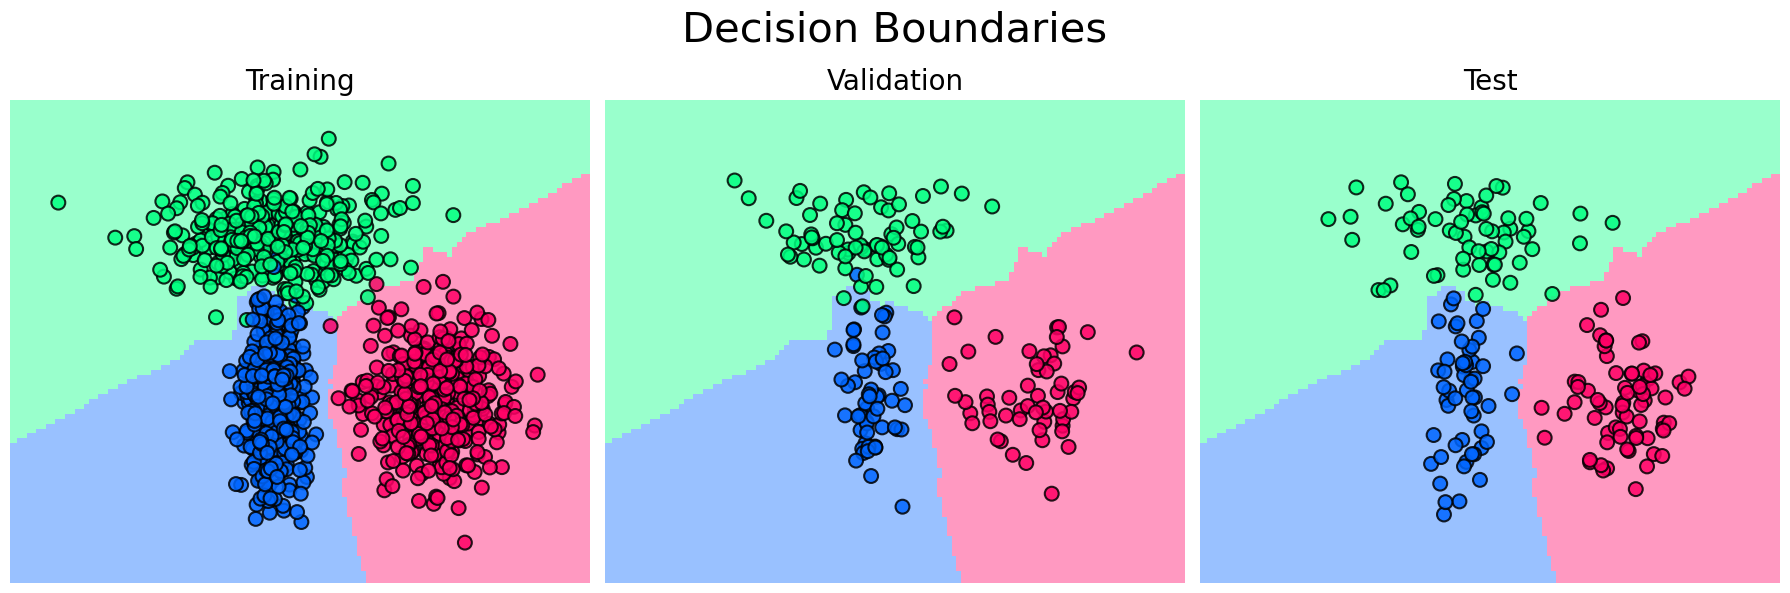

In [8]:
# Visualize the decision boundaries of the k-Nearest Neighbors classifier
vis.show_decision_boundaries(knn_vectorized, h=0.03)

## Evaluation of the Classifier

To conclude our notebook, let's assess the performance of the k-Nearest Neighbors classifier. We can determine the classifier's effectiveness by employing the accuracy metric on the testing set. (In case you are unfamiliar with the accuracy metric, look it up.) This evaluation step provides valuable insights into how well our classifier generalizes to new, unseen data.

In [7]:
y_pred = knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')

Accuracy: 1.000
